# Data Exploration and Classification

### Importing libraries

In [100]:
import pandas as pd
import MoreThanSentiments as mts
import nltk
import importlib
importlib.reload(mts)
mts.test_func()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from TRUNAJOD import ttr
import spacy
import re
import readability
from sklearn.model_selection import train_test_split
import xgboost as xgb
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
import string
import re
import textstat
import matplotlib.pyplot as plt
from nltk import FreqDist
import seaborn as sns
import random
import seaborn as sns
import ppscore as pps
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
import shap
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Load data

In [2]:
writtenAbstracts = pd.read_csv('writtenAbstracts.csv').drop(['Unnamed: 0', 'index'], axis = 1)
generatedAbstracts = pd.read_csv('generatedAbstracts.csv').drop(['Unnamed: 0'], axis = 1)

### Filtering the data

In [3]:
#Once again apply a filter so that the generated abstracts have a length of between 170 and 230 words
generatedAbstracts['abstractLength'] = generatedAbstracts['abstracts'].str.split().str.len()
generatedAbstracts = generatedAbstracts.loc[(generatedAbstracts['abstractLength'] >= 170) & (generatedAbstracts['abstractLength'] <= 230), ]
generatedAbstracts = generatedAbstracts.drop(['abstractLength'], axis = 1)
generatedAbstracts.columns = ['title', 'abstract']

In [4]:
#Subset the written abstracts based on which of the generated abstracts have a length between 170 and 230 words
writtenAbstracts = writtenAbstracts.loc[writtenAbstracts['title'].isin(generatedAbstracts['title'])] 

In [5]:
writtenAbstracts = writtenAbstracts.reset_index()
generatedAbstracts = generatedAbstracts.reset_index()

In [6]:
#Adding whether an abstract is written or generated
writtenAbstracts['GeneratedWritten'] = 'written'
generatedAbstracts['GeneratedWritten'] = 'generated'

In [7]:
df = pd.concat([writtenAbstracts, generatedAbstracts]).drop(['index'], axis = 1)
df = df.reset_index().drop(['index'], axis = 1)

#### Exporting the abstracts to allow language analysis

In [8]:
abstracts = df['abstract'].to_frame()
abstracts.to_csv('abstracts.csv') #Export to use languagetool on mac

In [9]:
grammarErrors = pd.read_csv('GrammarErrors.csv').drop(['Unnamed: 0'], axis = 1)

In [10]:
grammarErrors['errors'] = grammarErrors[['errorsUS', 'errorsGB']].min(axis=1)

### Contactenating the data

In [11]:
#Adding the errors to the dataframe as this data is acquired using a different laptop
df['errors'] = grammarErrors['errors']

In [12]:
df.head()

,title,abstract,GeneratedWritten,errors
0,Big Data and Data Science in Critical Care,The digitalization of the health-care system ...,written,0
1,Surgical data science - from concepts toward c...,Recent developments in data science in genera...,written,0
2,Developments in data science solutions for car...,Competition for resources is a key question i...,written,0
3,An Effective Data Science Technique for IoT-As...,Patients are required to be observed and trea...,written,1
4,Master's Degree in Health Data Science: Implem...,Health data science is an emerging discipline...,written,0


## Data exploration

### Data cleaning

In [13]:
def remove_punctuations(input_col):
    """To remove all the punctuations present in the text.Input the text column"""
    table = str.maketrans('','',string.punctuation)
    return input_col.translate(table)

In [14]:
writtenAbstracts['abstractWithoutPunc'] = writtenAbstracts['abstract'].apply(remove_punctuations)
generatedAbstracts['abstractWithoutPunc'] = generatedAbstracts['abstract'].apply(remove_punctuations)

In [15]:
def build_corpus(text_col):
    """To build a text corpus by stitching all the records together.Input the text column"""
    corpus = ""
    for abstract in text_col:
        corpus += abstract
    return corpus.lower().split()

In [16]:
writtenCorpus = build_corpus(writtenAbstracts['abstractWithoutPunc'])
generatedCorpus = build_corpus(generatedAbstracts['abstractWithoutPunc'])

In [17]:
writtenCorpus_without_stop = [word for word in writtenCorpus if word not in stopwords.words("english")]
generatedCorpus_without_stop = [word for word in generatedCorpus if word not in stopwords.words("english")]

In [18]:
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

In [19]:
def preprocess_lem_sent(abstract):
    lem_abstract = []
    for sentence in abstract:        
        lem_text = str(sentence).lower()
        clean_lem_text = [wnl.lemmatize(i) for i in lem_text.split()]
        lem_abstract.append(' '.join(clean_lem_text))
    return lem_abstract

In [20]:
df['lemmatizedAbstract'] = preprocess_lem_sent(df['abstract'])

In [21]:
def tokenize_abstract(abstract, punc = False):
    tokenized_abstract = []
    if punc == False: 
        for sentence in abstract:
            tokenized_abstract.append(word_tokenize(sentence))
    elif punc == True:
        for sentence in abstract:
            tokenized_abstract.append(word_tokenize(sentence.translate(str.maketrans('', '', string.punctuation))))
    return(tokenized_abstract)

In [22]:
df['tokenizedFullAbstractWithPunc'] = tokenize_abstract(df['lemmatizedAbstract'])

In [23]:
df['mtsTokenization'] = df.lemmatizedAbstract.apply(mts.sent_tok)

### ZIpfs law

In [24]:
def plot_word_frequency(words, filename, top_n=10, including = True):
    """Function to plot the word frequencies"""
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    plt.figure(figsize=(15,5))
    if including == True:
        plt.title("Most Frequent Words in the Corpus - Including STOPWORDS")
    else:
        plt.title("Most Frequent Words in the Corpus - Excluding STOPWORDS")
    plt.ylabel("Count")
    plt.xlabel("Word")
    sns.barplot(labels,counts)
    plt.savefig(filename)
    return plt

In [25]:
def zipf(text_corpus, filename):
    fd = FreqDist()
    ranks = []
    freqs = []
    for i in text_corpus:
        fd[i] += 1
    for rank, word in enumerate(fd):
        ranks.append(rank+1)
        freqs.append(fd[word])
    plt.figure(figsize=(20, 7))
    plt.loglog(freqs,ranks)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title("Zipf's Distribution")
    plt.savefig(filename)
    plt.show()

#### Written abstracts with stopwords

<module 'matplotlib.pyplot' from 'C:\\Users\\mrijnders001\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

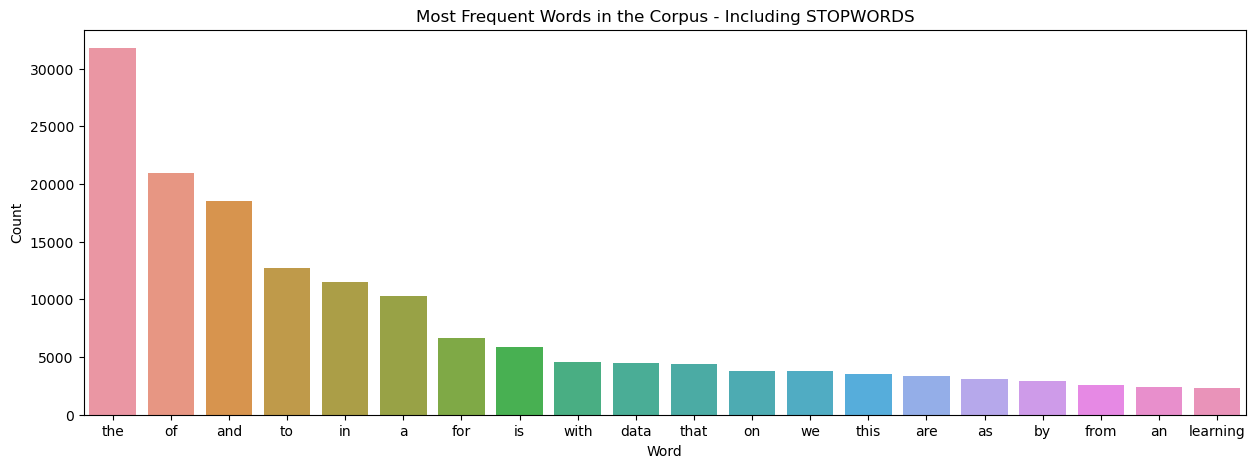

In [29]:
plot_word_frequency(writtenCorpus, 'ZipfsLawWrittenInclStopwords.png', 20) #for the written abstracts 

#### Generated abstracts with stopwords

<module 'matplotlib.pyplot' from 'C:\\Users\\mrijnders001\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

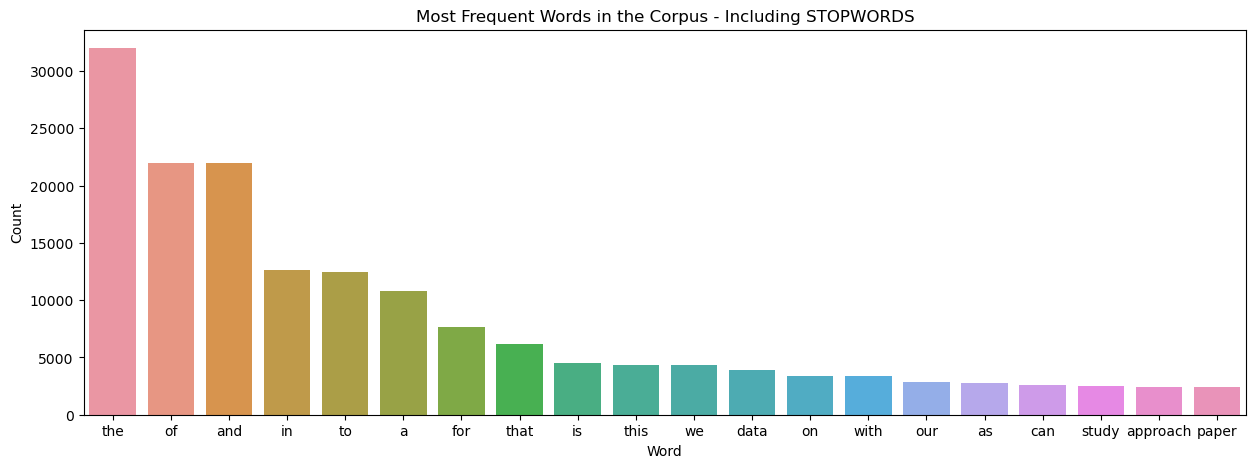

In [30]:
plot_word_frequency(generatedCorpus, 'ZipfsLawGeneratedInclStopwords.png',20) #For the generated abstracts

#### Written abstracts without stopwords

<module 'matplotlib.pyplot' from 'C:\\Users\\mrijnders001\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

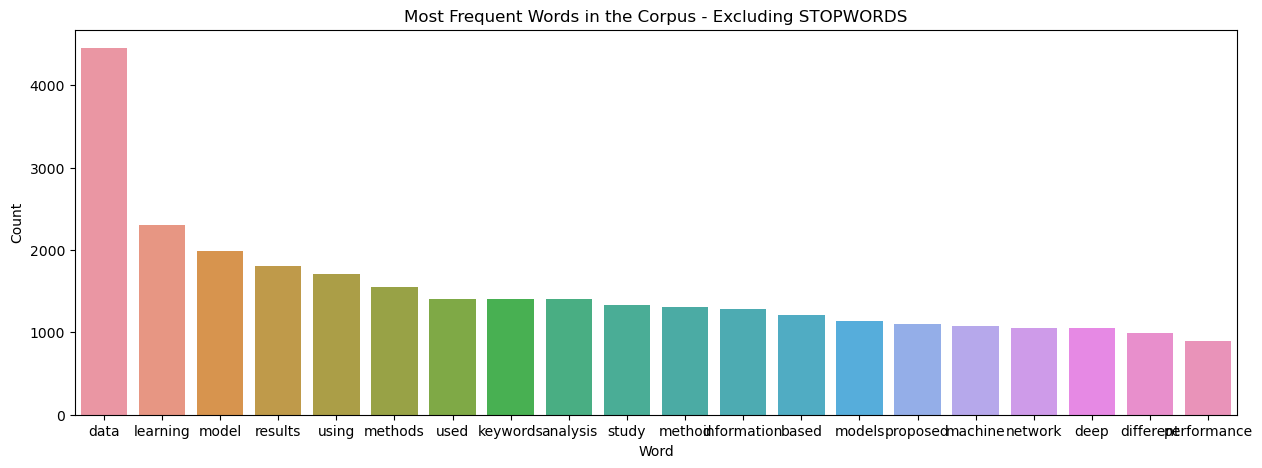

In [31]:
plot_word_frequency(writtenCorpus_without_stop, 'ZipfsLawWritenExclStopwords.png', 20, False)

#### Generated abstract without stopwords

<module 'matplotlib.pyplot' from 'C:\\Users\\mrijnders001\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

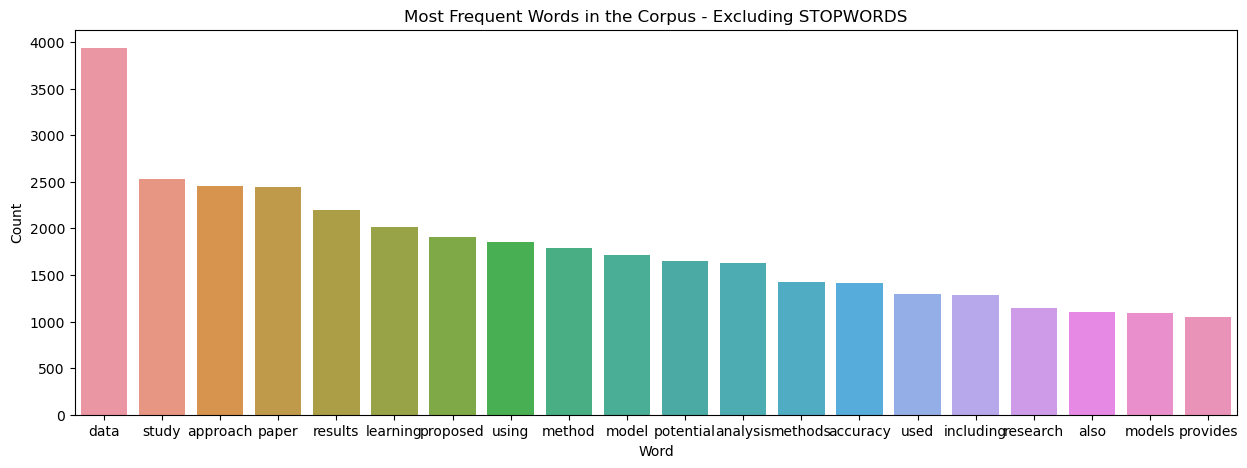

In [32]:
plot_word_frequency(generatedCorpus_without_stop, 'ZipfsLawGeneratedExclStopwords.png', 20, False)

#### Zipfs law whole corpus - written

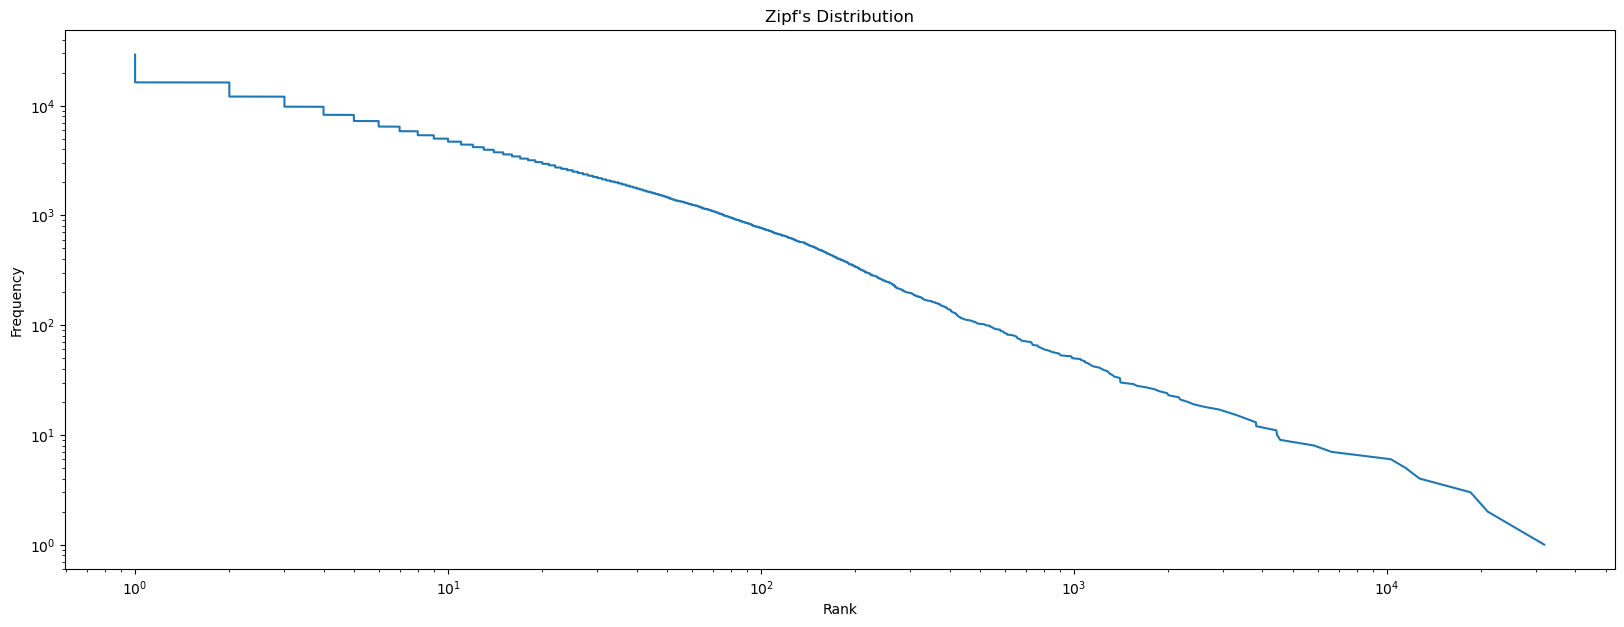

In [33]:
zipf(writtenCorpus, 'ZipfsDistributionWritten.png')

#### Zipfs law whole corpus - generated

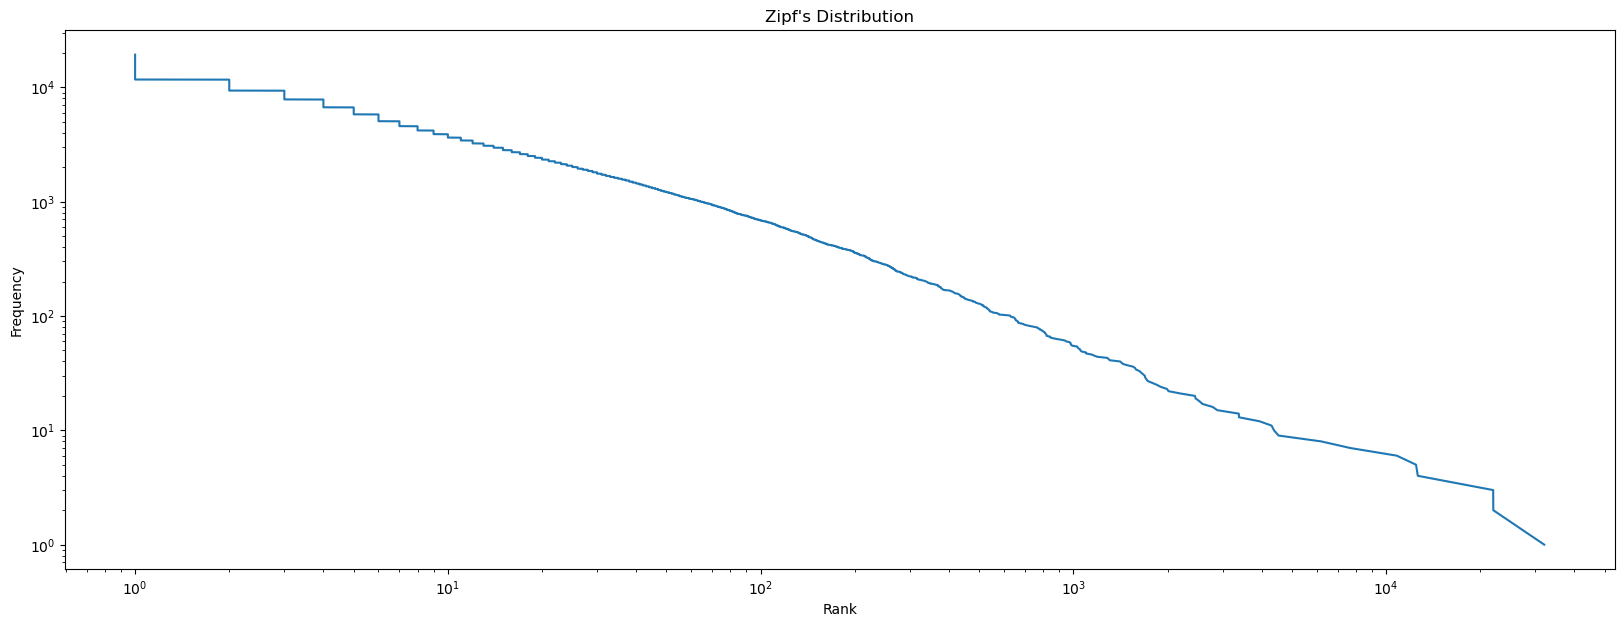

In [34]:
zipf(generatedCorpus, 'ZipfsDistributionGenerated.png')

### Heaps' law

In [114]:
def heaps_law(text):
    vocab = set(text)
    word_count = len(text)
    vocab_count = len(vocab)
    return word_count, vocab_count

#### Heaps' law written

In [36]:
wordsWritten = []
vocabWritten = []
for i in range(1, len(writtenCorpus)+1):
    word_count, vocab_count = heaps_law(writtenCorpus[:i])
    wordsWritten.append(word_count)
    vocabWritten.append(vocab_count)

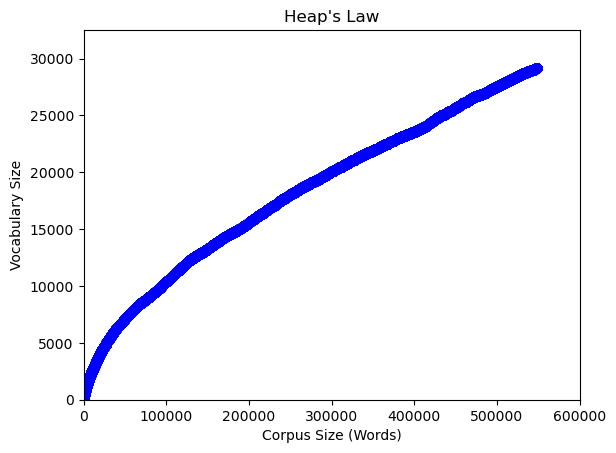

In [37]:
fig, ax = plt.subplots()
ax.plot(wordsWritten, vocabWritten, 'bo')
ax.set(xlabel='Corpus Size (Words)', ylabel='Vocabulary Size', title="Heap's Law")
plt.ylim(0, 32500)
plt.xlim(0, 600000)
plt.savefig('HeapsLawWritten.png')
plt.show()

#### Heaps' law generated

In [115]:
wordsGenerated = []
vocabGenerated = []
for i in range(1, len(writtenCorpus)+1):
    word_count, vocab_count = heaps_law(generatedCorpus[:i])
    wordsGenerated.append(word_count)
    vocabGenerated.append(vocab_count)

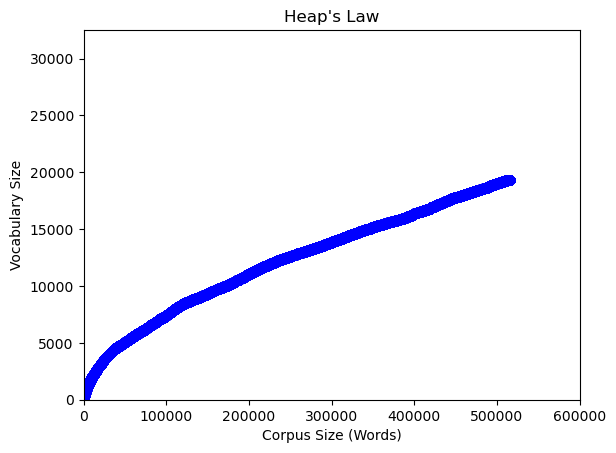

In [116]:
fig, ax = plt.subplots()
ax.plot(wordsGenerated, vocabGenerated, 'bo')
ax.set(xlabel='Corpus Size (Words)', ylabel='Vocabulary Size', title="Heap's Law")
plt.ylim(0, 32500)
plt.xlim(0, 600000)
plt.savefig('HeapsLawGenerated.png')
plt.show()

### Doc2Vec

In [24]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokenizedFullAbstractWithPunc'])]

In [25]:
model = Doc2Vec(vector_size = 300, min_count = 0, epochs = 10, dm = 1, seed = 1, workers = 1) 
model.build_vocab(documents)

In [26]:
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [27]:
random.seed(42)
doc2vecRep = []
for i in range(len(documents)):
    doc2vecRep.append(model.infer_vector(documents[i].words))

In [28]:
df['doc2vec'] = doc2vecRep

In [29]:
counter = 0 
list_similar = []
list_not_similar = []
for i in df['doc2vec'].loc[df['GeneratedWritten'] == 'written']:
    sims = model.dv.most_similar([i], topn = 2)
    
    titleWrittenText = df['title'][(sims[0][0])]
    titleGeneratedText = df['title'][(sims[1][0])]

    if titleWrittenText == titleGeneratedText and len(list_similar) < 1:
        list_similar.append(titleWrittenText)
        counter += 1
    elif titleWrittenText != titleGeneratedText and len(list_not_similar) < 1:
        list_not_similar.append(titleWrittenText)
    elif titleWrittenText == titleGeneratedText:
        counter += 1
    
        
print('Abstract where the written and generated text are most similar to eachother:',  
      str(counter/len(df['doc2vec'].loc[df['GeneratedWritten'] == 'written']) * 100) + '%')

Abstract where the written and generated text are most similar to eachother: 12.718658892128278%


In [31]:
print(list_similar)
df.loc[df['title'].isin(list_similar), ['abstract', 'GeneratedWritten']].values

['Intracranial Pressure Monitoring Signals After Traumatic Brain Injury: A Narrative Overview and Conceptual Data Science Framework']


array([[' Continuous intracranial pressure (ICP) monitoring is a cornerstone of neurocritical care after severe brain injuries such as traumatic brain injury and acts as a biomarker of secondary brain injury. With the rapid development of artificial intelligent (AI) approaches to data analysis, the acquisition, storage, real-time analysis, and interpretation of physiological signal data can bring insights to the field of neurocritical care bioinformatics. We review the existing literature on the quantification and analysis of the ICP waveform and present an integrated framework to incorporate signal processing tools, advanced statistical methods, and machine learning techniques in order to comprehensively understand the ICP signal and its clinical importance. Our goals were to identify the strengths and pitfalls of existing methods for data cleaning, information extraction, and application. In particular, we describe the use of ICP signal analytics to detect intracranial hypertension a

In [32]:
print(list_not_similar)
df.loc[df['title'].isin(list_not_similar), ['abstract', 'GeneratedWritten']].values

['Big Data and Data Science in Critical Care']


array([[' The digitalization of the health-care system has resulted in a deluge of clinical big data and has prompted the rapid growth of data science in medicine. Data science, which is the field of study dedicated to the principled extraction of knowledge from complex data, is particularly relevant in the critical care setting. The availability of large amounts of data in the ICU, the need for better evidence-based care, and the complexity of critical illness makes the use of data science techniques and data-driven research particularly appealing to intensivists. Despite the increasing number of studies and publications in the field, thus far there have been few examples of data science projects that have resulted in successful implementations of data-driven systems in the ICU. However, given the expected growth in the field, intensivists should be familiar with the opportunities and challenges of big data and data science. The present article reviews the definitions, types of algori

### MoreThanSentiments

In [109]:
def statistical_test(df_features, measure):
    written = df_features[df_features['GeneratedWritten'] == 'written'][measure]
    generated = df_features[df_features['GeneratedWritten'] == 'generated'][measure]
    t_stat, t_test_p_value = ttest_ind(written, generated)
    U_stat, kstest_p_value = mannwhitneyu(written, generated)
    print('Pairwise testing on ', measure, ', t-test p-value: ', t_test_p_value, ' Mann Whitney U test p-value: ', kstest_p_value)

In [83]:
docs = df['mtsTokenization'].values
docs_vol = len(df) * 0.3
df['boilerplate'] = mts.Boilerplate(docs, n = 4, min_doc = docs_vol, get_ngram = False)

Flag the Sentence: 100%|██████████| 5488/5488 [00:00<00:00, 16440.69it/s]


'======================== Boilerplate Calculation Started ========================='

'======================== Boilerplate Calculation Finished ========================'

In [25]:
df['redundancy'] = mts.Redundancy(docs, n = 10)

Get the Redundancy: 100%|██████████| 5488/5488 [00:00<00:00, 14896.82it/s]


In [26]:
lemmatizedDocs = df['lemmatizedAbstract'].values
df['specificity'] = mts.Specificity(lemmatizedDocs)

Get the Specificity: 100%|██████████| 5488/5488 [02:12<00:00, 41.26it/s]


In [31]:
MoreThanSentimentsScores = df.groupby(by=['GeneratedWritten'])[['boilerplate', 'redundancy', 'specificity']].mean()
MoreThanSentimentsScores

,boilerplate,redundancy,specificity
GeneratedWritten,,,
generated,0.0,0.001098,0.012599
written,0.0,0.000390,0.025036


In [30]:
MoreThanSentimentSD = df.groupby(by=['GeneratedWritten'])[['boilerplate', 'redundancy', 'specificity']].std()
MoreThanSentimentSD

,boilerplate,redundancy,specificity
GeneratedWritten,,,
generated,0.0,0.007536,0.014025
written,0.0,0.006316,0.022663


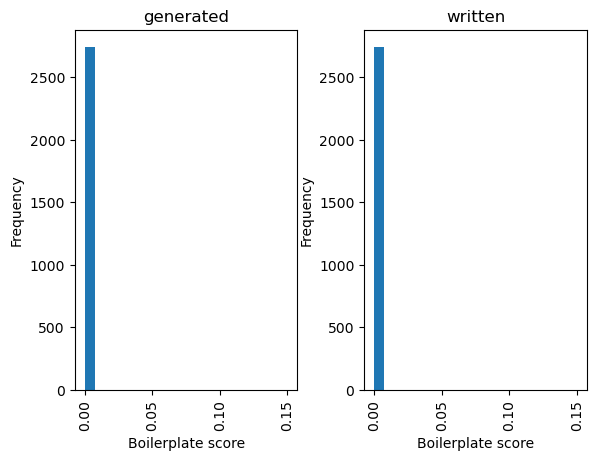

In [42]:
histogramBoilerplate = df.hist('boilerplate', by = 'GeneratedWritten', bins = 20, range = [0, 0.15])
for ax in histogramBoilerplate.flatten():
    ax.set_xlabel("Boilerplate score")
    ax.set_ylabel("Frequency")
    
plt.savefig('histogramBoilerplate.png')

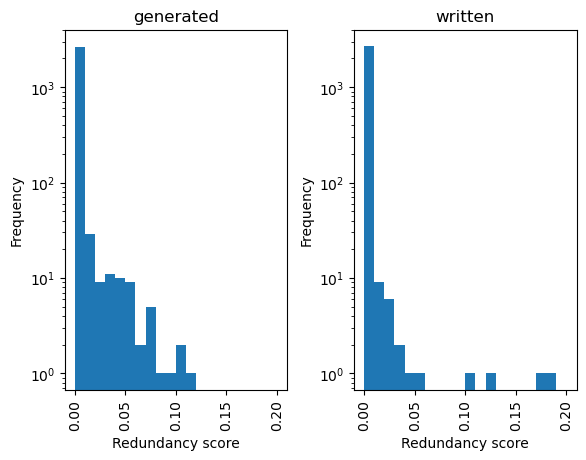

In [43]:
histogramRedundancy = df.hist('redundancy', by = 'GeneratedWritten', bins = 20, range = [0, 0.2], log = True)
for ax in histogramRedundancy.flatten():
    ax.set_xlabel("Redundancy score")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 4000)
    
plt.savefig('histogramRedundancy.png')

In [110]:
statistical_test(df, 'redundancy')

Pairwise testing on  redundancy , t-test p-value:  0.00016301500046604156  Mann Whitney U test p-value:  1.355552515713733e-08


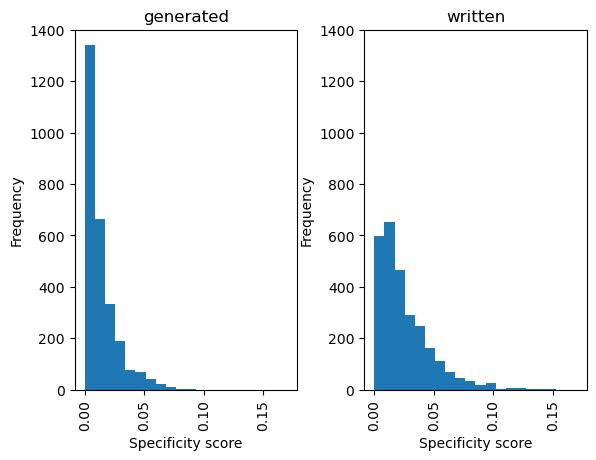

In [37]:
histogramSpecificity = df.hist('specificity', by = 'GeneratedWritten', bins = 20, range = [0, 0.17])
for ax in histogramSpecificity.flatten():
    ax.set_xlabel("Specificity score")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 1400)
    
plt.savefig('histogramSpecificity.png')

In [111]:
statistical_test(df, 'specificity')

Pairwise testing on  specificity , t-test p-value:  2.2659212046323308e-125  Mann Whitney U test p-value:  8.876267607498144e-127


### TRUNAJOD

In [58]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])
docs = df['lemmatizedAbstract'].apply(nlp)

In [59]:
lexical_diversity = []

for i in docs:
    lexical_diversity.append(ttr.type_token_ratio(i))

In [60]:
df['lexicalDiversity'] = lexical_diversity

In [61]:
trunajodScores = df.groupby(by=['GeneratedWritten'])['lexicalDiversity'].mean().to_frame()
trunajodScores

,lexicalDiversity
GeneratedWritten,
generated,1.0
written,1.0


In [62]:
trunajodSD = df.groupby(by = ['GeneratedWritten'])['lexicalDiversity'].std().to_frame()
trunajodSD

,lexicalDiversity
GeneratedWritten,
generated,0.0
written,0.0


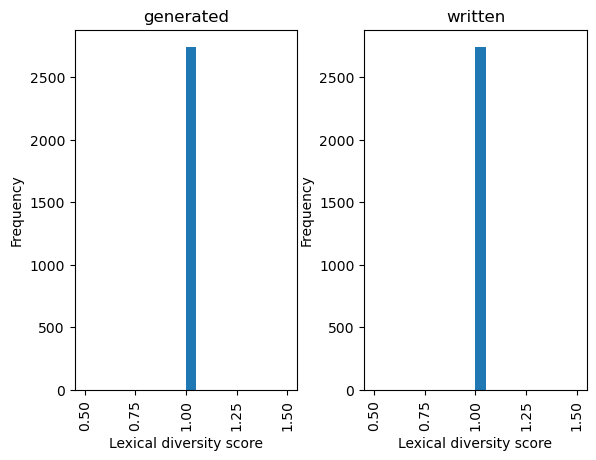

In [63]:
histogramLexicalDiversity = df.hist('lexicalDiversity', by = 'GeneratedWritten', bins = 20)
for ax in histogramLexicalDiversity.flatten():
    ax.set_xlabel("Lexical diversity score")
    ax.set_ylabel("Frequency")
    
plt.savefig('histogramLexicalDiversity.png')

### Readability

In [65]:
docs = df['abstract']
flesch_reading_ease = []
gunning_fog_index = []
ARI = []
Dale_Chall_Index = []
readingTime = []


for i in docs:
    flesch_reading_ease.append(textstat.flesch_reading_ease(i))
    gunning_fog_index.append(textstat.gunning_fog(i))
    ARI.append(textstat.automated_readability_index(i))
    Dale_Chall_Index.append(textstat.dale_chall_readability_score(i))
    readingTime.append(textstat.reading_time(i, ms_per_char = 14.69))
    

In [66]:
df['fleschReadingEase'] = flesch_reading_ease
df['gunningFogIndex'] = gunning_fog_index
df['ARI'] = ARI 
df['DaleChallIndex'] = Dale_Chall_Index
df['readingTime'] = readingTime

In [67]:
readabilityScores = df.groupby(['GeneratedWritten'])[['fleschReadingEase', 'gunningFogIndex',
                                                    'ARI', 'DaleChallIndex', 'readingTime', 'errors']].mean()
readabilityScores.head()

,fleschReadingEase,gunningFogIndex,ARI,DaleChallIndex,readingTime,errors
GeneratedWritten,,,,,,
generated,23.519293,15.947365,18.074563,10.584031,16.737518,1.745991
written,25.809012,15.633994,17.808054,10.856556,17.708400,2.912536


In [68]:
readabilitySD = df.groupby(['GeneratedWritten'])[['fleschReadingEase', 'gunningFogIndex',
                                                    'ARI', 'DaleChallIndex', 'readingTime', 'errors']].std()
readabilitySD

,fleschReadingEase,gunningFogIndex,ARI,DaleChallIndex,readingTime,errors
GeneratedWritten,,,,,,
generated,10.407489,1.877689,2.108335,0.695986,1.468489,2.697128
written,12.317719,2.489812,2.869091,0.826775,1.875129,3.248209


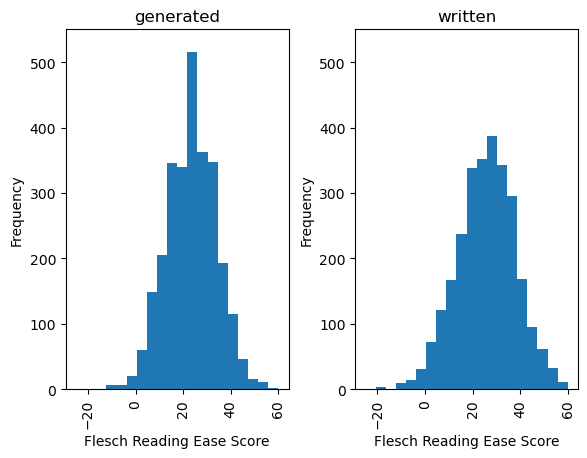

In [69]:
histogramFleschReadingEase = df.hist('fleschReadingEase', by = 'GeneratedWritten', bins = 20, range = [-25, 60])
for ax in histogramFleschReadingEase.flatten():
    ax.set_xlabel("Flesch Reading Ease Score")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 550)
    
plt.savefig('histogramFleschReadingEase.png')

In [113]:
statistical_test(df, 'fleschReadingEase')

Pairwise testing on  fleschReadingEase , t-test p-value:  1.1805268412771944e-13  Mann Whitney U test p-value:  3.4022128826770504e-15


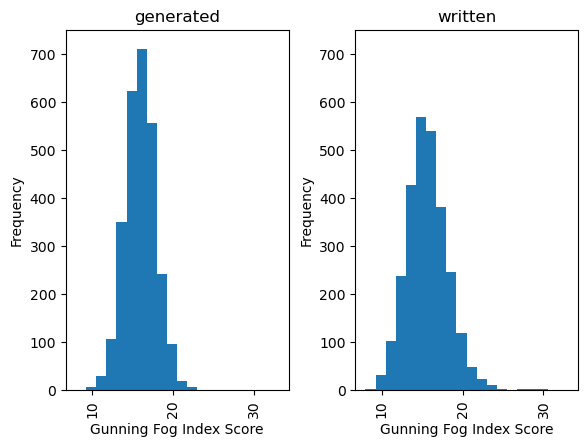

In [70]:
histogramGunningFogIndex = df.hist('gunningFogIndex', by = 'GeneratedWritten', bins = 20, range = [8, 33])
for ax in histogramGunningFogIndex.flatten():
    ax.set_xlabel("Gunning Fog Index Score")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 750)
    
plt.savefig('histogramGunningFogIndex.png')

In [114]:
statistical_test(df, 'gunningFogIndex')

Pairwise testing on  gunningFogIndex , t-test p-value:  1.4638873311813218e-07  Mann Whitney U test p-value:  1.612016315758644e-10


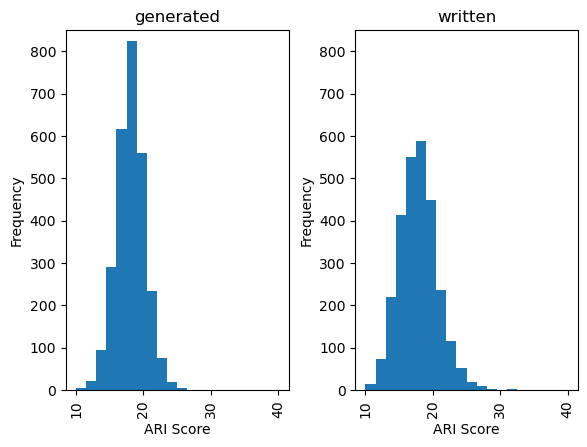

In [52]:
histogramARI = df.hist('ARI', by = 'GeneratedWritten', bins = 20, range = [10, 40])
for ax in histogramARI.flatten():
    ax.set_xlabel("ARI Score")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 850)
    
plt.savefig('histogramARI.png')

In [115]:
statistical_test(df, 'ARI')

Pairwise testing on  ARI , t-test p-value:  8.924921924440582e-05  Mann Whitney U test p-value:  7.518470243900569e-08


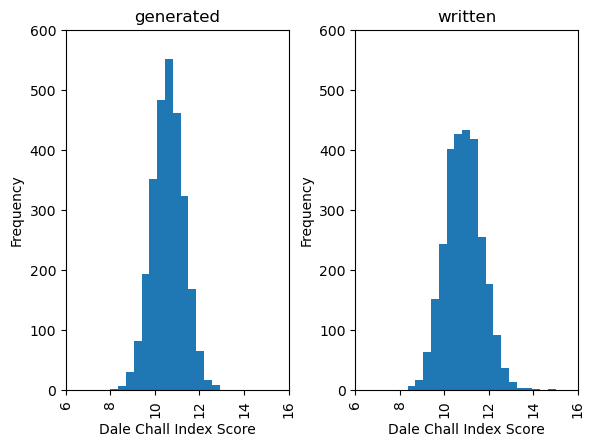

In [53]:
histogramDale = df.hist('DaleChallIndex', by = 'GeneratedWritten', bins = 20, range = [8, 15])
for ax in histogramDale.flatten():
    ax.set_xlabel("Dale Chall Index Score")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 600)
    ax.set_xlim(xmin = 6, xmax = 16)
    
plt.savefig('histogramDaleChallIndex.png')

In [116]:
statistical_test(df, 'DaleChallIndex')

Pairwise testing on  DaleChallIndex , t-test p-value:  3.05692359258724e-39  Mann Whitney U test p-value:  5.973126078311405e-34


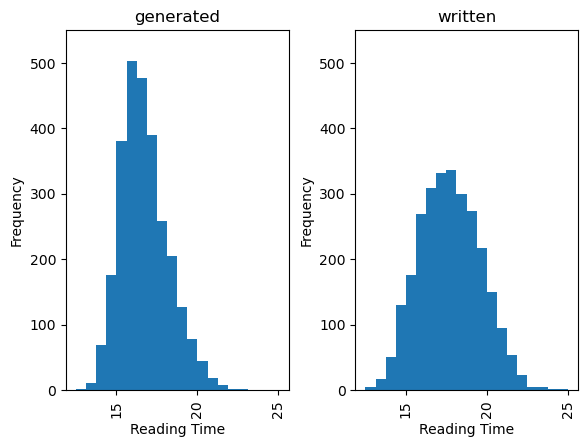

In [54]:
histogramReadingTime = df.hist('readingTime', by = 'GeneratedWritten', bins = 20, range = [12.5, 25])
for ax in histogramReadingTime.flatten():
    ax.set_xlabel("Reading Time")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 550)
    
plt.savefig('histogramReadingTime.png')

In [117]:
statistical_test(df, 'readingTime')

Pairwise testing on  readingTime , t-test p-value:  2.99277468601856e-97  Mann Whitney U test p-value:  1.8828791328504895e-91


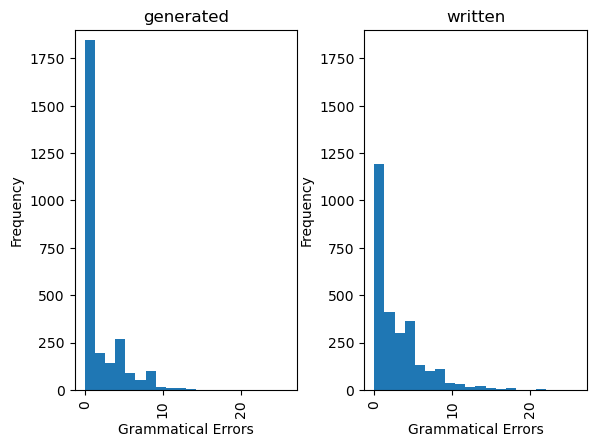

In [55]:
histogramGrammaticalErrors = df.hist('errors', by = 'GeneratedWritten', bins = 20, range = [0, 26])
for ax in histogramGrammaticalErrors.flatten():
    ax.set_xlabel("Grammatical Errors")
    ax.set_ylabel("Frequency")
    ax.set_ylim(ymin = 0, ymax = 1900)
    
plt.savefig('histogramGrammaticalErrors.png')

In [118]:
statistical_test(df, 'errors')

Pairwise testing on  errors , t-test p-value:  1.275747130616354e-46  Mann Whitney U test p-value:  1.7776334661429843e-83


## Building the classifier

#### Removing the doc2vec representations

In [56]:
df = df.drop(columns = ['doc2vec']) 

### Encode and split the data

In [57]:
le = preprocessing.LabelEncoder()

In [58]:
le.fit(df['GeneratedWritten'])
df['encodedY'] = le.transform(df['GeneratedWritten'])

In [59]:
df.head()

,title,abstract,GeneratedWritten,errors,lemmatizedAbstract,tokenizedFullAbstractWithPunc,mtsTokenization,boilerplate,redundancy,specificity,lexicalDiversity,fleschReadingEase,gunningFogIndex,ARI,DaleChallIndex,readingTime,encodedY
0,Big Data and Data Science in Critical Care,The digitalization of the health-care system ...,written,0,the digitalization of the health-care system h...,"[the, digitalization, of, the, health-care, sy...",[the digitalization of the health-care system ...,0.0,0.0,0.000000,1.0,37.23,16.23,17.4,9.78,14.51,1
1,Surgical data science - from concepts toward c...,Recent developments in data science in genera...,written,0,recent development in data science in general ...,"[recent, development, in, data, science, in, g...",[recent development in data science in general...,0.0,0.0,0.027650,1.0,23.09,19.04,21.4,11.58,18.49,1
2,Developments in data science solutions for car...,Competition for resources is a key question i...,written,0,competition for resource is a key question in ...,"[competition, for, resource, is, a, key, quest...",[competition for resource is a key question in...,0.0,0.0,0.023585,1.0,27.66,17.02,20.3,12.03,18.85,1
3,An Effective Data Science Technique for IoT-As...,Patients are required to be observed and trea...,written,1,patient are required to be observed and treate...,"[patient, are, required, to, be, observed, and...",[patient are required to be observed and treat...,0.0,0.0,0.000000,1.0,36.59,13.23,15.2,10.51,16.88,1
4,Master's Degree in Health Data Science: Implem...,Health data science is an emerging discipline...,written,0,health data science is an emerging discipline ...,"[health, data, science, is, an, emerging, disc...",[health data science is an emerging discipline...,0.0,0.0,0.042553,1.0,41.80,15.17,15.3,11.06,15.41,1


In [62]:
train, test = train_test_split(df, test_size = 0.3, random_state = 42)

### Doc2Vec on training data

In [63]:
trainDocuments = [TaggedDocument(doc, [i]) for i, doc in enumerate(train['tokenizedFullAbstractWithPunc'])]

In [64]:
len(trainDocuments)

3841

In [65]:
model = Doc2Vec(vector_size = 300, min_count = 0, epochs = 10, dm = 1, seed = 1, workers = 1) 
model.build_vocab(trainDocuments)

In [66]:
model.train(trainDocuments, total_examples = model.corpus_count, epochs = model.epochs)

In [67]:
doc2vecTrain = {}
for idx, row in train.iterrows():
    doc2vecTrain[idx] = model.infer_vector(row['tokenizedFullAbstractWithPunc'])


In [68]:
embedCols = []
for i in range(1, 301):
    embedCols.append('vec' + str(i))

In [69]:
doc2vecTrain = pd.DataFrame.from_dict(doc2vecTrain, orient = 'index', columns = embedCols)

In [70]:
train = pd.concat([train, doc2vecTrain], axis = 1)

### Doc2Vec on test data

In [73]:
doc2vecTest = {}
for idx, row in test.iterrows():
    doc2vecTest[idx] = model.infer_vector(row['tokenizedFullAbstractWithPunc'])

In [76]:
doc2vecTest = pd.DataFrame.from_dict(doc2vecTest, orient = 'index', columns = embedCols)

In [77]:
test = pd.concat([test, doc2vecTest], axis = 1)

### Specify the training data & testing data for the different models

#### Training data

In [78]:
train = train.drop(['title', 'abstract', 'lemmatizedAbstract',
                   'tokenizedFullAbstractWithPunc', 'mtsTokenization', 'GeneratedWritten'], axis = 1)

In [79]:
train.head()

,errors,boilerplate,redundancy,specificity,lexicalDiversity,fleschReadingEase,gunningFogIndex,ARI,DaleChallIndex,readingTime,...,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299,vec300
321,0,0.0,0.0,0.005780,1.0,24.17,16.04,17.0,10.09,14.88,...,0.211735,0.201176,-0.020386,0.088743,0.042232,0.206813,0.120638,-0.130653,0.065226,-0.391806
871,2,0.0,0.0,0.029240,1.0,43.73,13.45,13.7,10.40,13.66,...,-0.078306,0.150345,0.110446,0.228075,0.142846,0.446377,0.299772,0.015409,0.227167,-0.256424
169,0,0.0,0.0,0.035354,1.0,23.77,17.69,16.9,11.19,16.89,...,-0.055210,0.346669,0.149298,-0.165100,0.174618,0.009462,-0.007700,0.188700,0.310063,-0.051549
1934,6,0.0,0.0,0.024876,1.0,33.88,18.05,19.1,12.44,16.39,...,0.105578,0.088372,0.371543,0.103689,0.089675,0.398063,0.289715,-0.390359,0.047798,-0.103250
2447,2,0.0,0.0,0.009901,1.0,8.30,18.69,21.6,10.62,18.05,...,0.108451,0.188059,-0.141418,0.026643,0.425657,0.199443,0.104597,-0.140533,0.144690,-0.001756


In [80]:
notFeatures = embedCols.copy()
notFeatures.append('encodedY')

In [81]:
X_train_doc2vec = train[embedCols]
X_train_features = train.drop(columns = notFeatures, axis = 1)
X_train_combination = train.drop(['encodedY'], axis = 1)
Y_train = train['encodedY']

#### Test data

In [82]:
test = test.drop(['title', 'abstract', 'lemmatizedAbstract',
                   'tokenizedFullAbstractWithPunc', 'mtsTokenization', 'GeneratedWritten'], axis = 1)

In [83]:
X_test_doc2vec = test[embedCols]
X_test_features = test.drop(columns = notFeatures, axis = 1)
X_test_combination = test.drop(['encodedY'], axis = 1)
Y_test = test['encodedY']

### Classifier

#### Using the doc2vec embeddings

In [84]:
classifierDoc2Vec = XGBClassifier()
classifierDoc2Vec.fit(X_train_doc2vec, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [85]:
y_predDoc2Vec = classifierDoc2Vec.predict(X_test_doc2vec)
accuracy_score(Y_test, y_predDoc2Vec)

0.8391013964784456

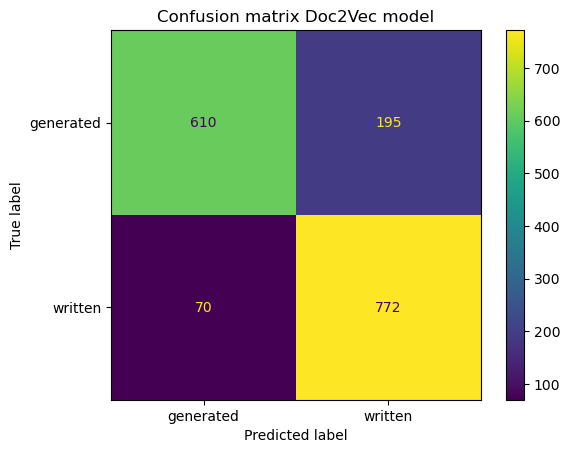

In [86]:
cm = confusion_matrix(Y_test, y_predDoc2Vec, labels=classifierDoc2Vec.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.inverse_transform(classifierDoc2Vec.classes_))
disp.plot()
plt.title('Confusion matrix Doc2Vec model')
plt.savefig('confusionMatrixEmbeddings.png')
plt.show()

#### Using features derivered from the text

In [88]:
classifierFeatures = XGBClassifier()
classifierFeatures.fit(X_train_features, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [89]:
y_predFeatures = classifierFeatures.predict(X_test_features)
accuracy_score(Y_test, y_predFeatures)

0.7237401335761992

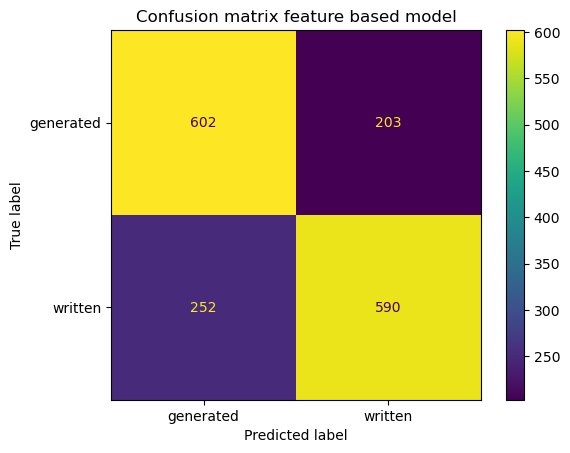

In [90]:
cm = confusion_matrix(Y_test, y_predFeatures, labels=classifierFeatures.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.inverse_transform(classifierFeatures.classes_))
disp.plot()
plt.title('Confusion matrix feature based model')
plt.savefig('confusionMatrixFeatures.png')
plt.show()

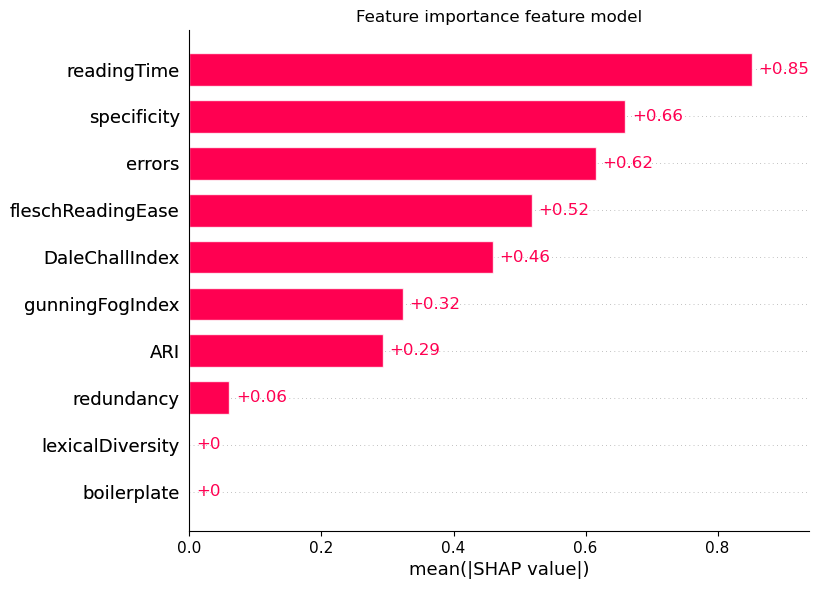

In [91]:
# Use the SHAP library to explain the model's predictions on the testing data
explainer = shap.Explainer(classifierFeatures)
shap_values = explainer(X_test_features)

# Plot the feature importance using SHAP
shap.plots.bar(shap_values, show = False)
plt.title('Feature importance feature model')
plt.savefig('meanShapValuesFeatureModel.png')
plt.show()

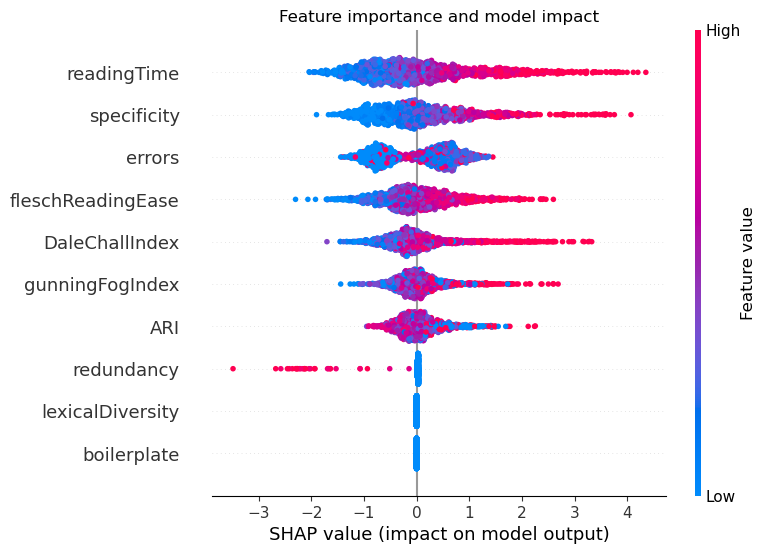

In [92]:
shap.summary_plot(shap_values, X_test_features, show = False)
plt.title('Feature importance and model impact')
plt.savefig('summaryPlotFeatureModel.png')
plt.show()

#### Using both doc2vec embeddings and features derived from the text

In [93]:
classifierCombination = XGBClassifier()
classifierCombination.fit(X_train_combination, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [94]:
y_predCombination = classifierCombination.predict(X_test_combination)
accuracy_score(Y_test, y_predCombination)
accCombinedModel = accuracy_score(Y_test, y_predCombination)
accCombinedModel

0.864602307225258

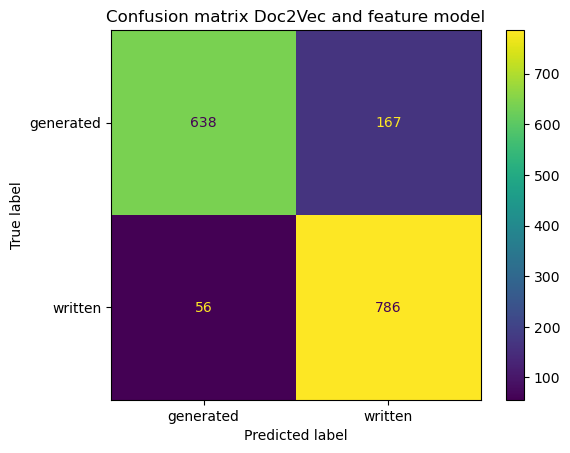

In [95]:
cm = confusion_matrix(Y_test, y_predCombination, labels=classifierCombination.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.inverse_transform(classifierCombination.classes_))
disp.plot()
plt.title('Confusion matrix Doc2Vec and feature model')
plt.savefig('confusionMatrixCombined.png')
plt.show()

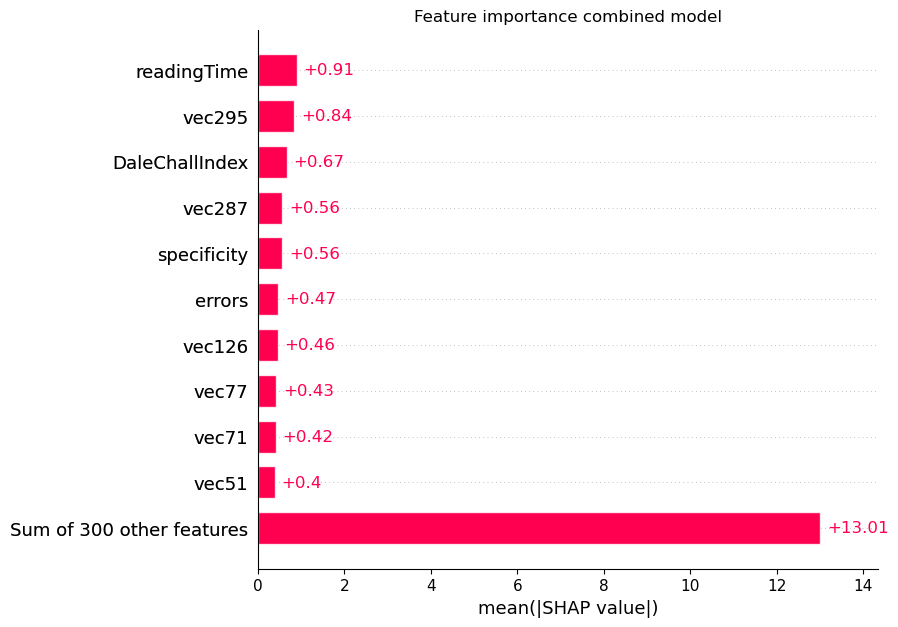

In [96]:
# Use the SHAP library to explain the model's predictions on the testing data
explainer = shap.Explainer(classifierCombination)
shap_values = explainer(X_test_combination)

# Plot the feature importance using SHAP
# shap.summary_plot(shap_values, X_test_combination, max_display = 10)
shap.plots.bar(shap_values, show = False, max_display = 11)
plt.title('Feature importance combined model')
plt.savefig('meanShapValuesCombinedModel.png')
plt.show()

In [97]:
features = ['errors', 'boilerplate', 'redundancy', 'specificity', 'lexicalDiversity', 'fleschReadingEase',
           'gunningFogIndex', 'ARI', 'DaleChallIndex', 'readingTime']

In [100]:
variableSets = [embedCols, features]

aggregatedShapValues = {}
for variableSet in variableSets:
    featureIndices = [i for i, feature in enumerate(X_test_combination.columns) if feature in variableSet]
    selectShapValues = shap_values.values[:, featureIndices]
    aggregatedShapValues['+'.join(variableSet)] = np.mean(np.abs(selectShapValues), axis = 0)

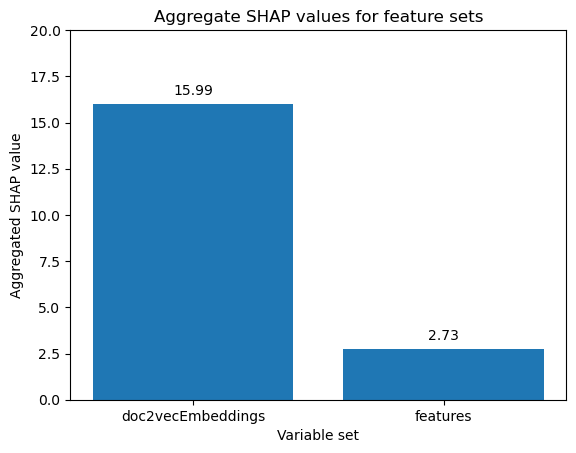

In [101]:
labels = ['doc2vecEmbeddings', 'features']
values = [np.sum(item) for item in aggregatedShapValues.values()]
plt.bar(labels, values)
plt.xlabel('Variable set')
plt.ylabel('Aggregated SHAP value')
plt.title('Aggregate SHAP values for feature sets')
plt.ylim(0, 20)

for i in range(len(labels)):
    plt.text(labels[i], values[i] + 0.5, str(round(values[i], 2)), ha='center')

plt.savefig('importanceOfFeaturesGroupsCombinedModel.png')
plt.show()


### Leave-one-out modelling

#### Leave out errors

In [104]:
classifierCombinationNoErrors = XGBClassifier()
X_train_combination_NoErrors = X_train_combination.drop(columns = ['errors'])
X_test_combination_NoErrors = X_test_combination.drop(columns = ['errors'])

classifierCombinationNoErrors.fit(X_train_combination_NoErrors, Y_train)
y_predNoErrors = classifierCombinationNoErrors.predict(X_test_combination_NoErrors)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoErrors))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoErrors) - accCombinedModel)

Accuracy score without errors:  0.8548876745598057
Drop(-)/Increase(+) in accuracy:  -0.00971463266545225


#### Leave out boilerplate

In [105]:
classifierCombinationNoBoilerplate = XGBClassifier()
X_train_combination_NoBoilerplate = X_train_combination.drop(columns = ['boilerplate'])
X_test_combination_NoBoilerplate = X_test_combination.drop(columns = ['boilerplate'])

classifierCombinationNoBoilerplate.fit(X_train_combination_NoBoilerplate, Y_train)
y_predNoBoilerplate = classifierCombinationNoBoilerplate.predict(X_test_combination_NoBoilerplate)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoBoilerplate))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoBoilerplate) - accCombinedModel)

Accuracy score without errors:  0.864602307225258
Drop(-)/Increase(+) in accuracy:  0.0


#### Leave out redundancy

In [106]:
classifierCombinationNoRedundancy = XGBClassifier()
X_train_combination_NoRedundancy = X_train_combination.drop(columns = ['redundancy'])
X_test_combination_NoRedundancy = X_test_combination.drop(columns = ['redundancy'])

classifierCombinationNoRedundancy.fit(X_train_combination_NoRedundancy, Y_train)
y_predNoRedundancy = classifierCombinationNoRedundancy.predict(X_test_combination_NoRedundancy)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoRedundancy))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoRedundancy) - accCombinedModel)

Accuracy score without errors:  0.864602307225258
Drop(-)/Increase(+) in accuracy:  0.0


#### Leave out specificity

In [107]:
classifierCombinationNoSpecificity = XGBClassifier()
X_train_combination_NoSpecificity = X_train_combination.drop(columns = ['specificity'])
X_test_combination_NoSpecificity = X_test_combination.drop(columns = ['specificity'])

classifierCombinationNoSpecificity.fit(X_train_combination_NoSpecificity, Y_train)
y_predNoSpecificity = classifierCombinationNoSpecificity.predict(X_test_combination_NoSpecificity)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoSpecificity))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoSpecificity) - accCombinedModel) 

Accuracy score without errors:  0.8524590163934426
Drop(-)/Increase(+) in accuracy:  -0.012143290831815423


#### Leave out lexical diversity

In [108]:
classifierCombinationNoLexicalDiversity = XGBClassifier()
X_train_combination_NoLexicalDiversity = X_train_combination.drop(columns = ['lexicalDiversity'])
X_test_combination_NoLexicalDiversity = X_test_combination.drop(columns = ['lexicalDiversity'])

classifierCombinationNoLexicalDiversity.fit(X_train_combination_NoLexicalDiversity, Y_train)
y_predNoLexicalDiversity = classifierCombinationNoLexicalDiversity.predict(X_test_combination_NoLexicalDiversity)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoLexicalDiversity))
print('Drop(-)/Increase(+) in accuracy: ', (accuracy_score(Y_test, y_predNoLexicalDiversity) - accCombinedModel) * 100)

Accuracy score without errors:  0.864602307225258
Drop(-)/Increase(+) in accuracy:  0.0


#### Leave out Flesch Reading Ease

In [109]:
classifierCombinationNoFleschReadingEase = XGBClassifier()
X_train_combination_NoFleschReadingEase = X_train_combination.drop(columns = ['fleschReadingEase'])
X_test_combination_NoFleschReadingEase = X_test_combination.drop(columns = ['fleschReadingEase'])

classifierCombinationNoFleschReadingEase.fit(X_train_combination_NoFleschReadingEase, Y_train)
y_predNoFleschReadingEase = classifierCombinationNoFleschReadingEase.predict(X_test_combination_NoFleschReadingEase)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoFleschReadingEase))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoFleschReadingEase) - accCombinedModel) 

Accuracy score without errors:  0.8615664845173042
Drop(-)/Increase(+) in accuracy:  -0.0030358227079537725


#### Leave out Gunning Fog Index

In [110]:
classifierCombinationNoGunningFogIndex = XGBClassifier()
X_train_combination_NoGunningFogIndex = X_train_combination.drop(columns = ['gunningFogIndex'])
X_test_combination_NoGunningFogIndex = X_test_combination.drop(columns = ['gunningFogIndex'])

classifierCombinationNoGunningFogIndex.fit(X_train_combination_NoGunningFogIndex, Y_train)
y_predNoGunningFogIndex = classifierCombinationNoGunningFogIndex.predict(X_test_combination_NoGunningFogIndex)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoGunningFogIndex))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoGunningFogIndex) - accCombinedModel)

Accuracy score without errors:  0.8585306618093503
Drop(-)/Increase(+) in accuracy:  -0.006071645415907656


#### Leave out ARI

In [111]:
classifierCombinationNoARI = XGBClassifier()
X_train_combination_NoARI = X_train_combination.drop(columns = ['ARI'])
X_test_combination_NoARI = X_test_combination.drop(columns = ['ARI'])

classifierCombinationNoARI.fit(X_train_combination_NoARI, Y_train)
y_predNoARI = classifierCombinationNoARI.predict(X_test_combination_NoARI)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoARI))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoARI) - accCombinedModel) 

Accuracy score without errors:  0.8670309653916212
Drop(-)/Increase(+) in accuracy:  0.0024286581663631734


#### Leave out Dale Chall Index

In [112]:
classifierCombinationNoDaleChallIndex = XGBClassifier()
X_train_combination_NoDaleChallIndex = X_train_combination.drop(columns = ['DaleChallIndex'])
X_test_combination_NoDaleChallIndex = X_test_combination.drop(columns = ['DaleChallIndex'])

classifierCombinationNoDaleChallIndex.fit(X_train_combination_NoDaleChallIndex, Y_train)
y_predNoDaleChallIndex = classifierCombinationNoDaleChallIndex.predict(X_test_combination_NoDaleChallIndex)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoDaleChallIndex))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoDaleChallIndex) - accCombinedModel) 

Accuracy score without errors:  0.8627808136004858
Drop(-)/Increase(+) in accuracy:  -0.0018214936247722413


#### Leave out reading time

In [113]:
classifierCombinationNoReadingTime = XGBClassifier()
X_train_combination_NoReadingTime = X_train_combination.drop(columns = ['readingTime'])
X_test_combination_NoReadingTime = X_test_combination.drop(columns = ['readingTime'])

classifierCombinationNoReadingTime.fit(X_train_combination_NoReadingTime, Y_train)
y_predNoReadingTime = classifierCombinationNoReadingTime.predict(X_test_combination_NoReadingTime)
print('Accuracy score without errors: ', accuracy_score(Y_test, y_predNoReadingTime))
print('Drop(-)/Increase(+) in accuracy: ', accuracy_score(Y_test, y_predNoReadingTime) - accCombinedModel) 

Accuracy score without errors:  0.8627808136004858
Drop(-)/Increase(+) in accuracy:  -0.0018214936247722413
